In [1]:
# docker container start hfpt_July21

import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# batch_size=4 for the training set ...
# Run Date: Thursday, August 31, 2023
# Run Time: 00:20:43

# This was with a batch_size of 16 for the training data loader ...
# Run Date: Thursday, August 31, 2023
# Run Time: 00:19:34

#### Start with the imports

In [2]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
# from torchsummary import summary
from torchinfo import summary
from tqdm import tqdm

In [3]:
# only target the 2070 Super ...
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
!ls /tf/All/Data/Kaggle/Chest_X-ray_Images

test  train


In [5]:
# root folder of the data directory
dataDir = '/tf/All/Data/Kaggle/Chest_X-ray_Images'

#### Explore the data

In [6]:
# 2 types of x-rays ...
class_name = ['NORMAL','PNEUMONIA']

In [7]:
def get_list_files(dirName):
    files_list = os.listdir(dirName)
    return files_list

In [8]:
trainDir = dataDir + '/train/'
testDir = dataDir + '/test/'
print(trainDir)
print(testDir)

/tf/All/Data/Kaggle/Chest_X-ray_Images/train/
/tf/All/Data/Kaggle/Chest_X-ray_Images/test/


In [9]:
files_list_normal_train = get_list_files(trainDir + class_name[0])
files_list_pneu_train = get_list_files(trainDir + class_name[1])

In [10]:
files_list_normal_test = get_list_files(testDir + class_name[0])
files_list_pneu_test = get_list_files(testDir + class_name[1])

In [11]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883


In [12]:
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


In [13]:
## get random file to check
img = dataDir + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)

(1097, 1518)


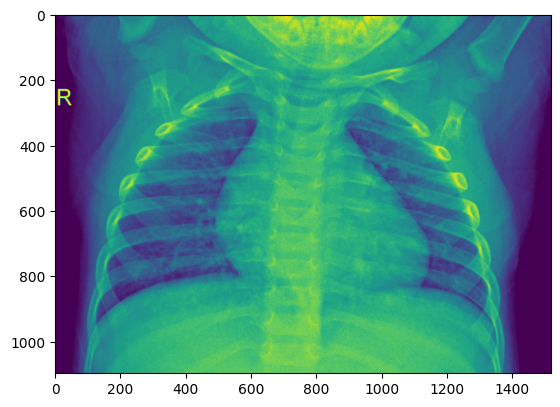

In [14]:
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(728, 1136)


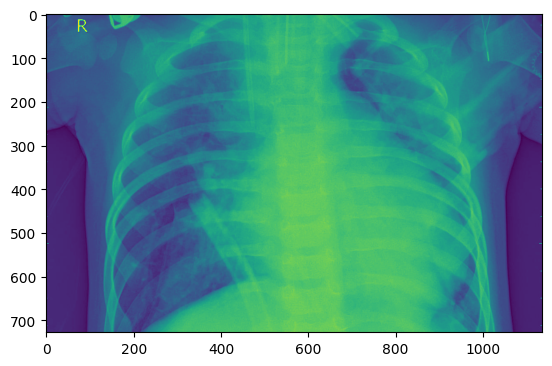

In [15]:
## get random file to check pneumona 
img = dataDir + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

The training transformation is changed in this notebook ...

In [16]:
# train_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                           [0.229, 0.224, 0.225])
# ])

train_transform = transforms.Compose([
    
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [17]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [18]:
# getting the train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(dataDir, 'train'), transform=train_transform)

The batch_size is changed from 16 to 4 for the training data loader ...

In [19]:
# train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=True)

In [20]:
class_names = train_data.classes
class_names

['NORMAL', 'PNEUMONIA']

In [21]:
test_data = datasets.ImageFolder(os.path.join(dataDir, 'test'), transform=test_transform)

In [22]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

In [23]:
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

Number of train images: 5232
Number of test images: 624


#### Define the Model

In [24]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(4)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        ) 

        # TRANSITION BLOCK 

        self.pool22 = nn.MaxPool2d(2, 2) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
           
        ) 

        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            #nn.BatchNorm2d(32)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(14),
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(16),
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [25]:
# and of course, use cuda when you can!
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
model = Net().to(device)

In [27]:
summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2]                    --
├─Sequential: 1-1                        [8, 222, 222]             --
│    └─Conv2d: 2-1                       [8, 222, 222]             216
│    └─ReLU: 2-2                         [8, 222, 222]             --
├─MaxPool2d: 1-2                         [8, 111, 111]             --
├─Sequential: 1-3                        [16, 109, 109]            --
│    └─Conv2d: 2-3                       [16, 109, 109]            1,152
│    └─ReLU: 2-4                         [16, 109, 109]            --
├─MaxPool2d: 1-4                         [16, 54, 54]              --
├─Sequential: 1-5                        [10, 54, 54]              --
│    └─Conv2d: 2-5                       [10, 54, 54]              160
│    └─ReLU: 2-6                         [10, 54, 54]              --
├─MaxPool2d: 1-6                         [10, 27, 27]              --
├─Sequenti

#### Training Process

In [28]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)

        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        ## prediction on data
        y_pred = model(data)

        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))

In [29]:
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15

In [30]:
%%time
for epoch in range(EPOCHS):
    print("EPOCH number :", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('Current Learing Rate : ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH number : 0


Loss=0.692961573600769 Batch_id=1307 Accuracy=74.22: 100%|██████████| 1308/1308 [01:14<00:00, 17.61it/s] 


Current Learing Rate :  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624 (62.50%)

EPOCH number : 1


Loss=0.6931474208831787 Batch_id=1307 Accuracy=36.16: 100%|██████████| 1308/1308 [01:13<00:00, 17.85it/s]


Current Learing Rate :  0.01

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 2


Loss=0.6931471228599548 Batch_id=1307 Accuracy=25.78: 100%|██████████| 1308/1308 [01:17<00:00, 16.88it/s]


Current Learing Rate :  0.01

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 3


Loss=0.6931470632553101 Batch_id=1307 Accuracy=25.78: 100%|██████████| 1308/1308 [01:14<00:00, 17.53it/s]


Current Learing Rate :  0.01

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 4


Loss=0.6931471824645996 Batch_id=1307 Accuracy=25.78: 100%|██████████| 1308/1308 [01:16<00:00, 17.11it/s]


Current Learing Rate :  0.01

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 5


Loss=0.6931469440460205 Batch_id=1307 Accuracy=25.78: 100%|██████████| 1308/1308 [01:15<00:00, 17.28it/s]


Current Learing Rate :  0.005

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 6


Loss=0.6931473612785339 Batch_id=1307 Accuracy=25.78: 100%|██████████| 1308/1308 [01:16<00:00, 17.17it/s]


Current Learing Rate :  0.005

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 7


Loss=0.6931471228599548 Batch_id=1307 Accuracy=25.82: 100%|██████████| 1308/1308 [01:15<00:00, 17.35it/s]


Current Learing Rate :  0.005

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 8


Loss=0.6931472420692444 Batch_id=1307 Accuracy=25.80: 100%|██████████| 1308/1308 [01:14<00:00, 17.51it/s]


Current Learing Rate :  0.005

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 9


Loss=0.6931471824645996 Batch_id=1307 Accuracy=25.80: 100%|██████████| 1308/1308 [01:14<00:00, 17.51it/s]


Current Learing Rate :  0.005

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 10


Loss=0.6931473016738892 Batch_id=1307 Accuracy=25.78: 100%|██████████| 1308/1308 [01:15<00:00, 17.33it/s]


Current Learing Rate :  0.005

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 11


Loss=0.6931475400924683 Batch_id=1307 Accuracy=25.80: 100%|██████████| 1308/1308 [01:11<00:00, 18.22it/s]


Current Learing Rate :  0.0025

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 12


Loss=0.6931473016738892 Batch_id=1307 Accuracy=25.78: 100%|██████████| 1308/1308 [01:13<00:00, 17.77it/s]


Current Learing Rate :  0.0025

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 13


Loss=0.6931472420692444 Batch_id=1307 Accuracy=25.82: 100%|██████████| 1308/1308 [01:15<00:00, 17.22it/s]


Current Learing Rate :  0.0025

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

EPOCH number : 14


Loss=0.6931473612785339 Batch_id=1307 Accuracy=25.80: 100%|██████████| 1308/1308 [01:12<00:00, 18.15it/s]


Current Learing Rate :  0.0025

Test set: Average loss: 0.6931, Accuracy: 234/624 (37.50%)

CPU times: user 2h 1min 9s, sys: 21.4 s, total: 2h 1min 31s
Wall time: 20min 38s


Text(0.5, 1.0, 'Test Accuracy')

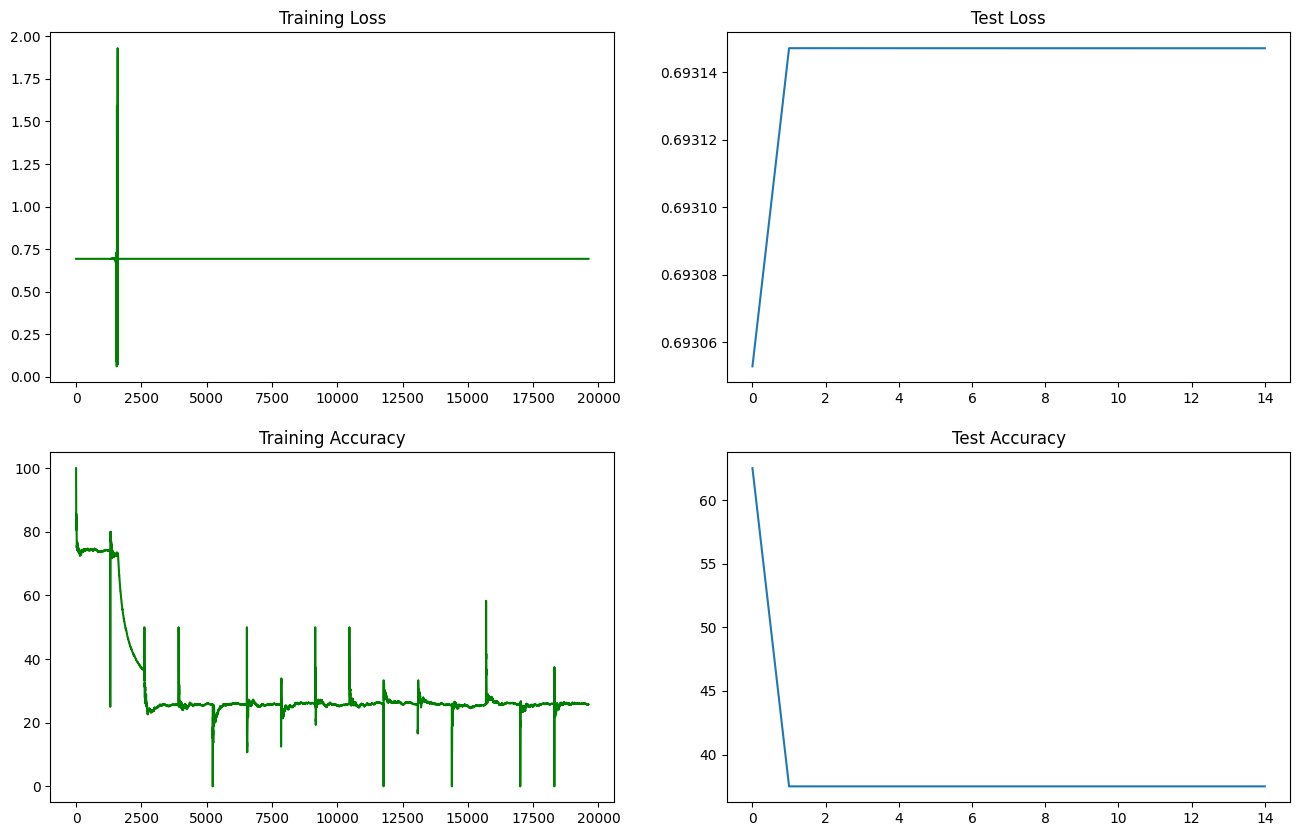

In [31]:
torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")

In [32]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Thursday, August 31, 2023
# Run Time: 00:20:43
